In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.python.keras import backend as k

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from tensorflow.keras import backend

from utils import * 
from config import parameters

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt
import math
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

2.0.0
base_dir: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency
Parameters(
  sentence_length_outlier = [0, 1, 2, 181, 252]
  bigram_window_size = 15
  bigram_max_rank = None
  stopword_list = ['financial', 'market', 'federal', 'bank', 'banking', 'bankers', 'speech', 'bi', 'review', 'year', 'reserve', 'policy', 'state', 'central', 'board', 'percent', 'rate', 'mr', 'alan', 'greenspan', 'ben', 'bernanke', 'janet', 'yellen', 'jerome', 'powell', 'vol', 'ha', 'wa', 'ii']
  ws_quarterly = 4
  ws_semiannually = 2
  ws_annually = 1
  strength_alpha = 0.9
  base_dir = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency
  data_dir = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/data
  output_base_dir = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output
  bis_raw_csv_filepath = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/data/bis_w_content_FINAL_20191213.csv
  fred_gdp_quarterly_csv_filepath = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_freque

In [2]:
def rescale_rolling(values, rolling_window):
    df = pd.DataFrame(values)
    normalized = (df - df.rolling(rolling_window).mean()) / df.rolling(rolling_window).std()
    return normalized

# ALIGN: convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :].reshape(-1)
        dataX.append(a)
        dataY.append(dataset[i + look_back, -1])
    return np.array(dataX), np.array(dataY)

def series_to_supervised(values, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(values) is list else values.shape[1]
    df = DataFrame(values)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in columns]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (j)) for j in columns]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in columns]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [69]:
def main(x1_index_name, index_name, num_epochs=30):
    print('x1_index_name:', x1_index_name)
    print('index_name:', index_name)
    
    if index_name == 'unemployment_not_adjusted':
        pkl_file_path = 'topn_50_rolling_3_period_x_y_dict_NOT_ALIGNED.pkl'
    elif index_name == 'inflation_rate_percentage_change':
        pkl_file_path = 'inflation_rolling_3_period_x_y_dict.pkl'
    processed_list_pkl_filepath = os.path.join(parameters.output_base_dir, pkl_file_path) 
    [period_dict, proposed_data_x_dict, fred_data_y_dict] = load_pkl(processed_list_pkl_filepath)
    print('Training(%d): %s - %s' % (n_train_num, period_dict[index_name][:n_train_num][0], period_dict[index_name][:n_train_num][-1]))
    print('Test(%d): %s - %s' % (len(period_dict[index_name])-n_train_num, period_dict[index_name][n_train_num], period_dict[index_name][-1]))
    
    y = pd.Series(fred_data_y_dict[index_name])
    # y = rescale_rolling(y, 3)

    x1, dataset = None, None
    if x1_index_name is not None:
        x1 = pd.Series(proposed_data_x_dict[x1_index_name][index_name])
        # x1 = rescale_rolling(x1, 3)
        dataset = pd.concat([x1, y], axis=1)
        dataset.columns = x1_index_name, index_name
    else:
        dataset = pd.DataFrame(y, columns=[index_name])

    feature_num = dataset.shape[1]
    values = dataset.values   # pd.Series -> numpy.ndarray

    # ensure all data is float
    values = values.astype('float32')

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # frame as supervised learning
    reframed = series_to_supervised(scaled, dataset.columns, 1, 1)   # scaled, values

    # drop columns we don't want to predict
    drop_cols = [colname for colname in reframed.columns if '(t)' in colname and index_name not in colname]
    reframed.drop(drop_cols, axis=1, inplace=True)

    # split into train and test sets
    values = reframed.values
    train = values[:n_train_num, :]
    test = values[n_train_num:, :]

    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # design network
    model = Sequential()
    model.add(LSTM(64, input_shape=(train_X.shape[1:])))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')

    # fit network
    history = model.fit(train_X, train_y, shuffle=False,
    batch_size=1,
    epochs=num_epochs,
    validation_split=0.1,
#     callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    verbose=1)

    # plot history
    fig = plt.figure()
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = concatenate((test_X[:,:-1], yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    yhat = inv_yhat[:,-1]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_X[:,:-1], test_y), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    test_y = inv_y[:,-1]

    # calculate RMSE
    rmse = sqrt(mean_squared_error(test_y, yhat))
    print('Test RMSE: %.4f' % rmse)

    fig.savefig('../output/image/%s_train%d_feature%d_%s_%.4f.png' % (index_name, n_train_num, feature_num, x1_index_name, rmse))
    
    return inv_yhat

In [57]:
# parameters
index_name = 'unemployment_not_adjusted'   # inflation_rate_percentage_change
pkl_file_path = 'topn_50_rolling_3_period_x_y_dict_NOT_ALIGNED.pkl'   #  inflation_rolling_3_period_x_y_dict.pkl

x1_index_name = None   # None, 'frequency', 'strength', 'emerging_topic_score'

n_train_num = 50

x1_index_name: None
index_name: unemployment_not_adjusted
Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/topn_50_rolling_3_period_x_y_dict_NOT_ALIGNED.pkl
Training(50): 1998_Q2 - 2010_Q3
Test(35): 2010_Q4 - 2019_Q2
Train on 45 samples, validate on 5 samples
Epoch 1/30
45/45 [==============================] - 3s 56ms/sample - loss: 0.1455 - val_loss: 0.0689
Epoch 2/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0718 - val_loss: 0.0496
Epoch 3/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0548 - val_loss: 0.0495
Epoch 4/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0506 - val_loss: 0.0466
Epoch 5/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0481 - val_loss: 0.0437
Epoch 6/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0415 - val_loss: 0.0410
Epoch 7/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0393 - val_loss: 0.0395
Epoch

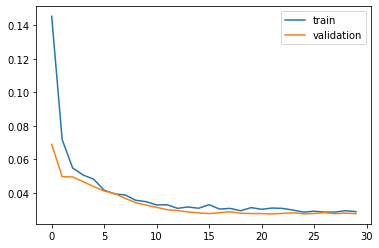

Test RMSE: 0.5311


In [58]:
main(None, 'unemployment_not_adjusted')

x1_index_name: frequency
index_name: unemployment_not_adjusted
Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/topn_50_rolling_3_period_x_y_dict_NOT_ALIGNED.pkl
Training(50): 1998_Q2 - 2010_Q3
Test(35): 2010_Q4 - 2019_Q2
Train on 45 samples, validate on 5 samples
Epoch 1/30
45/45 [==============================] - 2s 38ms/sample - loss: 0.1568 - val_loss: 0.0684
Epoch 2/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0665 - val_loss: 0.0430
Epoch 3/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0485 - val_loss: 0.0422
Epoch 4/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0484 - val_loss: 0.0401
Epoch 5/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0489 - val_loss: 0.0382
Epoch 6/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0452 - val_loss: 0.0367
Epoch 7/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0413 - val_loss: 0.0350


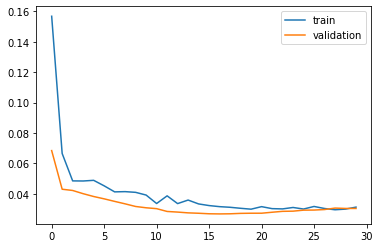

Test RMSE: 0.4900


In [59]:
main('frequency', 'unemployment_not_adjusted')

x1_index_name: strength
index_name: unemployment_not_adjusted
Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/topn_50_rolling_3_period_x_y_dict_NOT_ALIGNED.pkl
Training(50): 1998_Q2 - 2010_Q3
Test(35): 2010_Q4 - 2019_Q2
Train on 45 samples, validate on 5 samples
Epoch 1/30
45/45 [==============================] - 2s 38ms/sample - loss: 0.1283 - val_loss: 0.0622
Epoch 2/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0606 - val_loss: 0.0528
Epoch 3/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0554 - val_loss: 0.0522
Epoch 4/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0576 - val_loss: 0.0492
Epoch 5/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0548 - val_loss: 0.0464
Epoch 6/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0486 - val_loss: 0.0449
Epoch 7/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0503 - val_loss: 0.0428
E

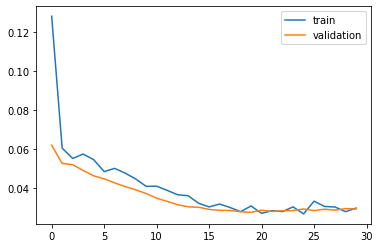

Test RMSE: 0.4670


In [60]:
main('strength', 'unemployment_not_adjusted')

x1_index_name: emerging_topic_score
index_name: unemployment_not_adjusted
Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/topn_50_rolling_3_period_x_y_dict_NOT_ALIGNED.pkl
Training(50): 1998_Q2 - 2010_Q3
Test(35): 2010_Q4 - 2019_Q2
Train on 45 samples, validate on 5 samples
Epoch 1/30
45/45 [==============================] - 2s 38ms/sample - loss: 0.1440 - val_loss: 0.0574
Epoch 2/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0624 - val_loss: 0.0401
Epoch 3/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0536 - val_loss: 0.0389
Epoch 4/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0527 - val_loss: 0.0365
Epoch 5/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0457 - val_loss: 0.0357
Epoch 6/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0465 - val_loss: 0.0332
Epoch 7/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0442 - val_lo

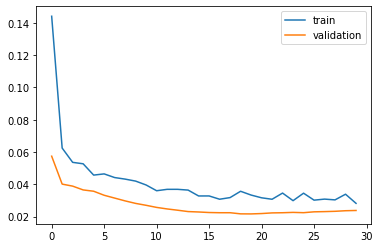

Test RMSE: 0.5528


In [61]:
main('emerging_topic_score', 'unemployment_not_adjusted')

### Inflation

x1_index_name: None
index_name: inflation_rate_percentage_change
Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/inflation_rolling_3_period_x_y_dict.pkl
Training(50): 1998_Q2 - 2010_Q4
Test(24): 2011_Q1 - 2016_Q4
Train on 45 samples, validate on 5 samples
Epoch 1/30
45/45 [==============================] - 2s 38ms/sample - loss: 0.1807 - val_loss: 0.1148
Epoch 2/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0688 - val_loss: 0.0831
Epoch 3/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0375 - val_loss: 0.0864
Epoch 4/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0345 - val_loss: 0.0864
Epoch 5/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0309 - val_loss: 0.0858
Epoch 6/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0309 - val_loss: 0.0853
Epoch 7/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0313 - val_loss: 0.0839
Epoch 8/

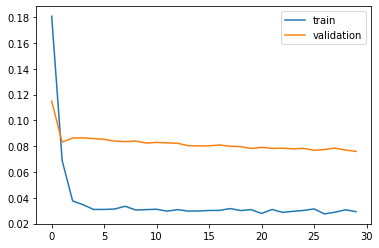

Test RMSE: 0.1897


In [62]:
main(None, 'inflation_rate_percentage_change')

x1_index_name: frequency
index_name: inflation_rate_percentage_change
Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/inflation_rolling_3_period_x_y_dict.pkl
Training(50): 1998_Q2 - 2010_Q4
Test(24): 2011_Q1 - 2016_Q4
Train on 45 samples, validate on 5 samples
Epoch 1/30
45/45 [==============================] - 2s 39ms/sample - loss: 0.1502 - val_loss: 0.0807
Epoch 2/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0377 - val_loss: 0.0771
Epoch 3/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0344 - val_loss: 0.0793
Epoch 4/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0339 - val_loss: 0.0806
Epoch 5/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0313 - val_loss: 0.0794
Epoch 6/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0318 - val_loss: 0.0777
Epoch 7/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0336 - val_loss: 0.0775
Epo

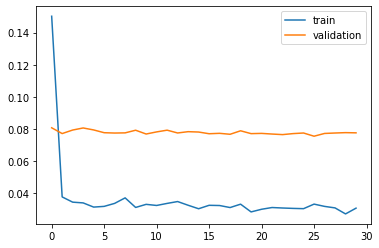

Test RMSE: 0.1987


In [63]:
main('frequency', 'inflation_rate_percentage_change')

x1_index_name: strength
index_name: inflation_rate_percentage_change
Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/inflation_rolling_3_period_x_y_dict.pkl
Training(50): 1998_Q2 - 2010_Q4
Test(24): 2011_Q1 - 2016_Q4
Train on 45 samples, validate on 5 samples
Epoch 1/30
45/45 [==============================] - 2s 39ms/sample - loss: 0.1433 - val_loss: 0.0749
Epoch 2/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0397 - val_loss: 0.0842
Epoch 3/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0333 - val_loss: 0.0868
Epoch 4/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0343 - val_loss: 0.0837
Epoch 5/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0322 - val_loss: 0.0823
Epoch 6/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0328 - val_loss: 0.0875
Epoch 7/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0360 - val_loss: 0.0830
Epoc

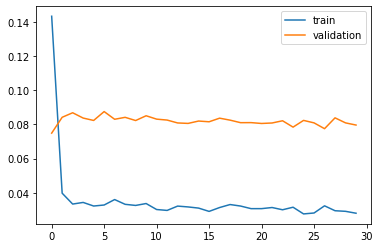

Test RMSE: 0.2015


In [64]:
main('strength', 'inflation_rate_percentage_change')

x1_index_name: emerging_topic_score
index_name: inflation_rate_percentage_change
Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/inflation_rolling_3_period_x_y_dict.pkl
Training(50): 1998_Q2 - 2010_Q4
Test(24): 2011_Q1 - 2016_Q4
Train on 45 samples, validate on 5 samples
Epoch 1/30
45/45 [==============================] - 3s 62ms/sample - loss: 0.1544 - val_loss: 0.0839
Epoch 2/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0418 - val_loss: 0.0808
Epoch 3/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0325 - val_loss: 0.0802
Epoch 4/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0346 - val_loss: 0.0798
Epoch 5/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0327 - val_loss: 0.0793
Epoch 6/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0355 - val_loss: 0.0792
Epoch 7/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0335 - val_loss:

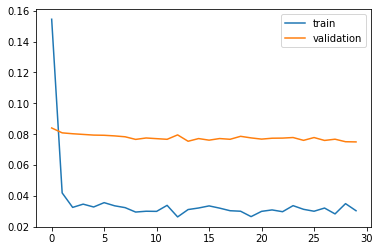

Test RMSE: 0.1971


In [65]:
main('emerging_topic_score', 'inflation_rate_percentage_change')

x1_index_name: strength
index_name: unemployment_not_adjusted
Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/topn_50_rolling_3_period_x_y_dict_NOT_ALIGNED.pkl
Training(50): 1998_Q2 - 2010_Q3
Test(35): 2010_Q4 - 2019_Q2
Train on 45 samples, validate on 5 samples
Epoch 1/100
45/45 [==============================] - 2s 38ms/sample - loss: 0.1260 - val_loss: 0.0605
Epoch 2/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0609 - val_loss: 0.0516
Epoch 3/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0568 - val_loss: 0.0497
Epoch 4/100
45/45 [==============================] - 0s 6ms/sample - loss: 0.0520 - val_loss: 0.0479
Epoch 5/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0509 - val_loss: 0.0463
Epoch 6/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0483 - val_loss: 0.0437
Epoch 7/100
45/45 [==============================] - 0s 6ms/sample - loss: 0.0473 - val_loss: 0

45/45 [==============================] - 0s 6ms/sample - loss: 0.0272 - val_loss: 0.0307
Epoch 79/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0261 - val_loss: 0.0311
Epoch 80/100
45/45 [==============================] - 0s 6ms/sample - loss: 0.0282 - val_loss: 0.0308
Epoch 81/100
45/45 [==============================] - 0s 6ms/sample - loss: 0.0269 - val_loss: 0.0313
Epoch 82/100
45/45 [==============================] - 0s 6ms/sample - loss: 0.0296 - val_loss: 0.0314
Epoch 83/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0255 - val_loss: 0.0315
Epoch 84/100
45/45 [==============================] - 0s 6ms/sample - loss: 0.0267 - val_loss: 0.0318
Epoch 85/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0281 - val_loss: 0.0309
Epoch 86/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0281 - val_loss: 0.0311
Epoch 87/100
45/45 [==============================] - 0s 5ms/sample - loss: 0.0275 - val_loss: 

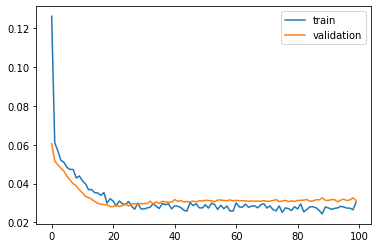

Test RMSE: 0.4600


In [70]:
inv_yhat = main('strength', 'unemployment_not_adjusted', num_epochs=100)

# Partial Dependency Plot

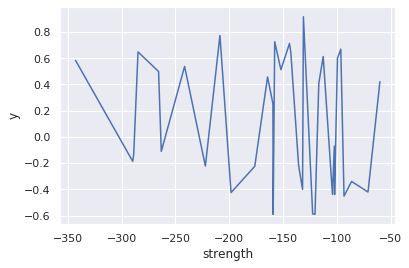

In [75]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame(inv_yhat, columns=['strength', 'y'])
ax = sns.lineplot(x="strength", y="y", data=df)

x1_index_name: frequency
index_name: unemployment_not_adjusted
Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/topn_50_rolling_3_period_x_y_dict_NOT_ALIGNED.pkl
Training(50): 1998_Q2 - 2010_Q3
Test(35): 2010_Q4 - 2019_Q2
Train on 45 samples, validate on 5 samples
Epoch 1/30
45/45 [==============================] - 2s 37ms/sample - loss: 0.1187 - val_loss: 0.0596
Epoch 2/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0640 - val_loss: 0.0529
Epoch 3/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0532 - val_loss: 0.0515
Epoch 4/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0578 - val_loss: 0.0477
Epoch 5/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0510 - val_loss: 0.0454
Epoch 6/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0509 - val_loss: 0.0424
Epoch 7/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0480 - val_loss: 0.0403


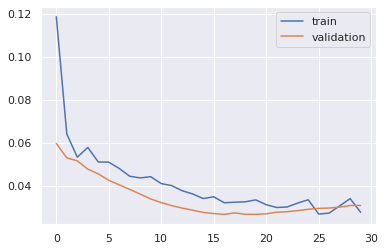

Test RMSE: 0.5159


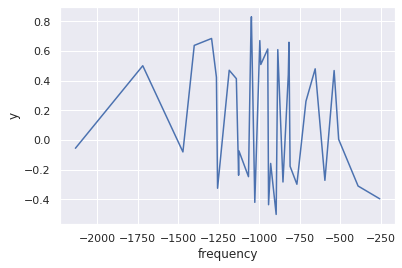

In [77]:
key_ = 'frequency'
inv_yhat = main(key_, 'unemployment_not_adjusted', num_epochs=30)
df = pd.DataFrame(inv_yhat, columns=[key_, 'y'])
ax = sns.lineplot(x=key_, y="y", data=df)

# Feature Importance via Random Shuffle

In [97]:
def main_2features_feature_importance_via_random(x1_index_name, index_name, num_epochs=30):
    print('x1_index_name:', x1_index_name)
    print('index_name:', index_name)
    
    if index_name == 'unemployment_not_adjusted':
        pkl_file_path = 'topn_50_rolling_3_period_x_y_dict_NOT_ALIGNED.pkl'
    elif index_name == 'inflation_rate_percentage_change':
        pkl_file_path = 'inflation_rolling_3_period_x_y_dict.pkl'
    processed_list_pkl_filepath = os.path.join(parameters.output_base_dir, pkl_file_path) 
    [period_dict, proposed_data_x_dict, fred_data_y_dict] = load_pkl(processed_list_pkl_filepath)
    print('Training(%d): %s - %s' % (n_train_num, period_dict[index_name][:n_train_num][0], period_dict[index_name][:n_train_num][-1]))
    print('Test(%d): %s - %s' % (len(period_dict[index_name])-n_train_num, period_dict[index_name][n_train_num], period_dict[index_name][-1]))
    
    y = pd.Series(fred_data_y_dict[index_name])
    # y = rescale_rolling(y, 3)

    x1, dataset = None, None
    if x1_index_name is not None:
        x1 = pd.Series(proposed_data_x_dict[x1_index_name][index_name])
        
        # random shuffle
        np.random.shuffle(x1.values)
        
        dataset = pd.concat([x1, y], axis=1)
        dataset.columns = x1_index_name, index_name
    else:
        print('this function is for 2 features (e.g. strength, y)')
        return

    feature_num = dataset.shape[1]
    values = dataset.values   # pd.Series -> numpy.ndarray

    # ensure all data is float
    values = values.astype('float32')

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # frame as supervised learning
    reframed = series_to_supervised(scaled, dataset.columns, 1, 1)   # scaled, values

    # drop columns we don't want to predict
    drop_cols = [colname for colname in reframed.columns if '(t)' in colname and index_name not in colname]
    reframed.drop(drop_cols, axis=1, inplace=True)

    # split into train and test sets
    values = reframed.values
    train = values[:n_train_num, :]
    test = values[n_train_num:, :]

    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # design network
    model = Sequential()
    model.add(LSTM(64, input_shape=(train_X.shape[1:])))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')

    # fit network
    history = model.fit(train_X, train_y, shuffle=False,
    batch_size=1,
    epochs=num_epochs,
    validation_split=0.1,
#     callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    verbose=1)

    # plot history
    fig = plt.figure()
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = concatenate((test_X[:,:-1], yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    yhat = inv_yhat[:,-1]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_X[:,:-1], test_y), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    test_y = inv_y[:,-1]

    # calculate RMSE
    rmse = sqrt(mean_squared_error(test_y, yhat))
    print('Test RMSE: %.4f' % rmse)

    fig.savefig('../output/image/%s_train%d_feature%d_%s_%.4f.png' % (index_name, n_train_num, feature_num, x1_index_name, rmse))

x1_index_name: strength
index_name: unemployment_not_adjusted
Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/topn_50_rolling_3_period_x_y_dict_NOT_ALIGNED.pkl
Training(50): 1998_Q2 - 2010_Q3
Test(35): 2010_Q4 - 2019_Q2
Train on 45 samples, validate on 5 samples
Epoch 1/30
45/45 [==============================] - 2s 38ms/sample - loss: 0.1178 - val_loss: 0.0575
Epoch 2/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0566 - val_loss: 0.0469
Epoch 3/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0481 - val_loss: 0.0455
Epoch 4/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0448 - val_loss: 0.0446
Epoch 5/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0459 - val_loss: 0.0431
Epoch 6/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0439 - val_loss: 0.0427
Epoch 7/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0418 - val_loss: 0.0416
E

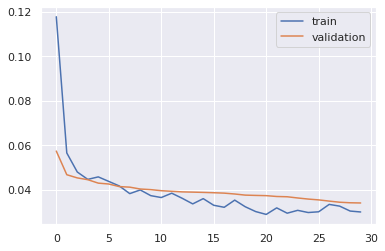

Test RMSE: 0.6105


In [98]:
main_2features_feature_importance_via_random('strength', 'unemployment_not_adjusted', num_epochs=30)

x1_index_name: frequency
index_name: unemployment_not_adjusted
Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/topn_50_rolling_3_period_x_y_dict_NOT_ALIGNED.pkl
Training(50): 1998_Q2 - 2010_Q3
Test(35): 2010_Q4 - 2019_Q2
Train on 45 samples, validate on 5 samples
Epoch 1/30
45/45 [==============================] - 3s 69ms/sample - loss: 0.1393 - val_loss: 0.0610
Epoch 2/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0623 - val_loss: 0.0472
Epoch 3/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0517 - val_loss: 0.0471
Epoch 4/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0528 - val_loss: 0.0445
Epoch 5/30
45/45 [==============================] - 0s 6ms/sample - loss: 0.0473 - val_loss: 0.0436
Epoch 6/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0465 - val_loss: 0.0408
Epoch 7/30
45/45 [==============================] - 0s 5ms/sample - loss: 0.0456 - val_loss: 0.0384


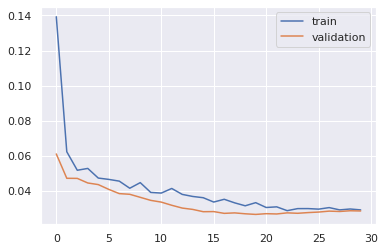

Test RMSE: 0.5292


In [99]:
main_2features_feature_importance_via_random('frequency', 'unemployment_not_adjusted', num_epochs=30)